/Users/mengzhao/miniconda2/envs/1_springboard_ds_track/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished


the score for test data: 0.3624603805868245
model file is saved as finalized_linear_model_2_bandgap.sav
done
MAE(mean absolute error) is 0.5589 eV
RMSLE is 0.311 eV


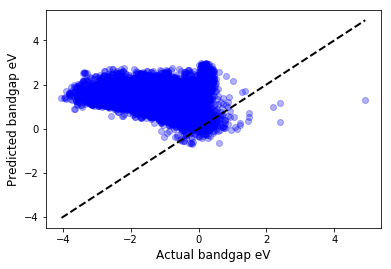

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

# Load the data
data = pd.read_csv("data_complete_w_features.csv",index_col = 0)
data = data.dropna()

features = data.drop(['formula','structure_obj', 
                      'composition',
                      'structure',
                      'composition_oxid',
                      'formation_energy_ev_natom',
                      'bandgap_energy_ev'], axis = 1)

features = features.astype(float)

target1 = data['formation_energy_ev_natom']
target2 = data['bandgap_energy_ev']

random_state = 42

# split data for target1 formation energy
X_train1, X_test1, y_train1, y_test1 = train_test_split(features, 
                                                        target1, 
                                                        test_size=0.3, 
                                                        random_state=random_state)

# split data for target2 bandgap
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, 
                                                        target2, 
                                                        test_size=0.3, 
                                                        random_state=random_state)

# Create the random grid

k_fold = 5
n_iter_search = 50

pca = PCA()
scaler= StandardScaler()
linear_regr = LinearRegression()

n_components = [int(x) for x in np.linspace(10, 140, num = 10)]

pipe_linear = make_pipeline(scaler,pca,linear_regr)

randomsearch_linear =  RandomizedSearchCV(pipe_linear,
                                          dict(pca__n_components=n_components), 
                                          n_iter = n_iter_search,
                                          cv = k_fold,
                                          random_state = 42,
                                          verbose = 1,
                                          n_jobs= -1)


# List of pipelines for ease of iteration
pipelines = [randomsearch_linear] 

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'pca with linear regression'} 

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train2, y_train2) 

    y_test_pred = pipe.predict(X_test2)
    score = pipe.score(X_test2, y_test2) 
    print("the score for test data: {}".format(score))

filename = 'finalized_linear_model_2_bandgap.sav'
joblib.dump(randomsearch_linear.best_estimator_, open(filename, 'wb'))
print('model file is saved as {}'.format(filename))
print ("done")

# calculate mean absolute error
y_pred_test2 = pipelines[0].predict(X_test2)

mean_absolute_error = mean_absolute_error(y_test2, y_pred_test2)
print("MAE(mean absolute error) is {} eV".format(round(mean_absolute_error,4)))

# number of testset
observations = len(y_test2)

pred_list = []
actual_list = []

pred_actual_diffs = []
most_negative1 = min(y_pred_test2)
most_negative2 = min(y_test2)

for pred, actual in zip(y_pred_test2,y_test2):
    pred_actual_diff = np.square(np.log(pred- most_negative2 + 1) - np.log(actual - most_negative2 + 1))
    pred_actual_diffs.append(pred_actual_diff)
    
evaluation = (1/observations)*np.sum(pred_actual_diffs)
rmsle = np.sqrt(evaluation)

print("RMSLE is {} eV".format(round(rmsle,4)))

# plot the figure
fontsize = 12
plt.scatter(y_test1, y_pred_test1, marker='o', color = 'blue', alpha = 0.3)
straightline_x = [min(y_test1), max(y_test1)]
straightline_y = [min(y_test1), max(y_test1)]
plt.plot(straightline_x, straightline_y, 'k--', linewidth=2)
plt.xlabel("Actual bandgap eV", fontsize = fontsize)
plt.ylabel("Predicted bandgap eV", fontsize = fontsize)
label1 = "MAE: {} eV".format(round(mean_absolute_error,2))
label2 = "ML algorithum:\n{}".format('linear')
# plt.text(1.5, -4, label1, fontsize=fontsize)
# plt.text(1.5, -3, label2, fontsize=fontsize)
plt.savefig("./actual vs. predicted bandgap_random_searchCV_linear.jpeg",dpi = 400)


# # Load ML model from file
# xgb_model = joblib.load(filename)
# print("training model loaded")
# print(xgb_model)